In [57]:
from utils.data_handling import *
from utils.sensor_optimisation_gpy_sparse import *
from parameters import *
import GPy

import sklearn.decomposition
import scipy
import matplotlib.pyplot as plt
np.random.seed(101)
%matplotlib inline

from tqdm import tqdm

In [2]:
parameters['i_end'] = 988
parameters['field_name'] = "Tracer"
parameters

{'i_start': 0,
 'i_end': 988,
 'crop': None,
 'field_name': 'Tracer',
 'cov_method': 'sample'}

In [3]:
loaded = initial_load_data(parameters, recompute=False)
ref_vtu, data_df, loc_df, time_df = loaded

100%|██████████| 1/1 [00:00<00:00,  6.08it/s]

### Loading files from original VTU
==> Import vtu files from 0 to 0


Number of Locations after cropping :  100040
==> Loading from : ../data/temp_data/cache_0_988_None/loc_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/time_Tracer.pkl
==> Loading from : ../data/temp_data/cache_0_988_None/data_Tracer.pkl


In [246]:
# Data for the regression
dim = 3
t = range(989)
X = loc_df.values #[I,:dim]
Y = data_df.values[:,t]#.reshape(-1,1) # [I,t].reshape(-1,1)
Y.shape

(100040, 989)

In [351]:
gamma = np.zeros((len(Z),len(Z)))
h = np.zeros((len(Z),len(Z)))

for i in tqdm.tqdm(range(0,10)):
    for j in range(len(Z)):
        gamma[i,j] = 0.5*np.abs(Z[i,:]-Z[j,:])**2
        h[i,j] = np.linalg.norm(X[i,:] - X[j,:],ord=2)
        
I = np.nonzero(gamma.flatten())
gamma = gamma.flatten()[I]
h = h.flatten()[I]

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence.

In [352]:
plt.figure(figsize=(15,7))
plt.scatter(h.flatten(),gamma.flatten())#,bins=20);
#plt.ylim(0,0.00000175)

Error in callback <function flush_figures at 0x7fa6093b6ae8> (for post_execute):


KeyboardInterrupt: 

In [299]:
gamma

array([2.81072659e-12, 6.02380976e-12, 1.28080304e-11, ...,
       3.92861169e-11, 8.25847737e-14, 5.94886725e-13])

In [300]:
gamma.flatten()[np.nonzero(gamma.flatten())] 


array([2.81072659e-12, 6.02380976e-12, 1.28080304e-11, ...,
       3.92861169e-11, 8.25847737e-14, 5.94886725e-13])

In [301]:
((X[0,:]- X[1,:]) /  np.linalg.norm(X[0,:]- X[1,:], ord=2)).dot(np.array([0,0,-1]))


-0.30656600218570085

Cuttingg the space : 

In [6]:
Y.shape

(100040, 989)

In [110]:
condition_0 = Y.sum(axis=1) > 10**0
condition_1 = Y.sum(axis=1) > 10**-1

condition_2 = Y.sum(axis=1) > 10**-2
condition_3 = Y.sum(axis=1) > 10**-4

np.sum(condition_3)

44925

In [111]:
np.max(Y.sum(axis=1))

417.1241469269741

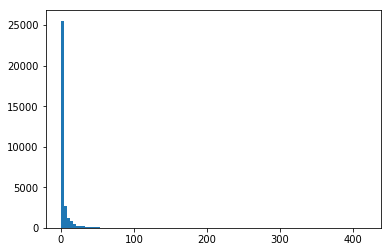

In [112]:
plt.hist(Y.sum(axis=1)[condition_2],bins = 100);

In [113]:
color = ['r' if condition_2[i] else None for i in range(len(Y)) ]


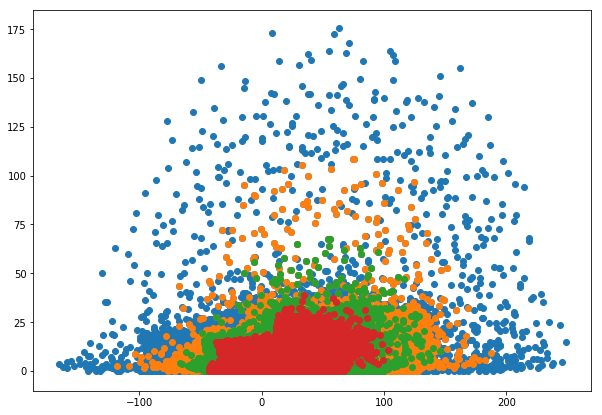

In [202]:
fig = plt.figure(figsize=(10,7))
ax1 = 'Y'
ax2 = 'Z'
plt.scatter(loc_df.loc[condition_3,ax1],loc_df.loc[condition_3,ax2])

plt.scatter(loc_df.loc[condition_2,ax1],loc_df.loc[condition_2,ax2])
plt.scatter(loc_df.loc[condition_1,ax1],loc_df.loc[condition_1,ax2])

plt.scatter(loc_df.loc[condition_0,ax1],loc_df.loc[condition_0,ax2])



In [108]:
loc_df.loc[:,ax2].max()

250.0

In [198]:
loc_cond = loc_df.loc[condition_3]
loc_cond[['X_r','Y_r']] = loc_cond[['X','Y']].round(decimals = -1)
max_z = loc_cond[['X_r','Y_r','Z']].groupby(['X_r','Y_r']).max()

 /home/aml718/anaconda3/envs/project/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


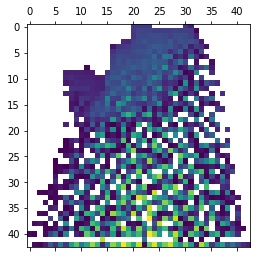

In [196]:
plt.matshow(max_z.values)

In [197]:
from scipy.interpolate import griddata

In [199]:
grid_x, grid_y = np.mgrid[0:1:50, 0:1:50]
grid_z0 = griddata(loc_cond[['X_r','Y_r']], max_z, (grid_x, grid_y), method='nearest')

TypeError: griddata() missing 1 required positional argument: 'xi'

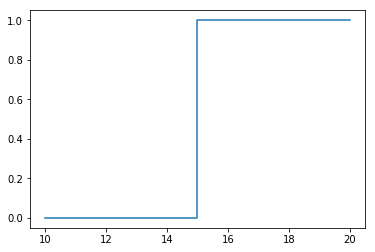

In [203]:
plt.plot([10,15,15,20],[0,0,1,1])

In [205]:
loc_cond = loc_df.loc[condition_3]
loc_cond[['X_r','Y_r']] = loc_cond[['X','Y']].round(decimals = -1)
max_z = loc_cond[['X_r','Y_r','Z']].groupby(['X_r','Y_r']).max()

array([[-359.68463275, -338.12365033,  250.        ],
       [ 359.68463275, -338.12365033,  250.        ],
       [ 359.68463275,  338.12365033,  250.        ],
       ...,
       [-171.45785248,  -51.8240821 ,   69.33607959],
       [-115.07028585,  -43.71573638,   60.90883801],
       [-131.3041365 ,  -39.4039321 ,   50.57458541]])

In [212]:
np.max(X[1,:])

359.684632748

In [270]:
resolution = (10,10,10)
thresh = 10**-4
bounds = {}
for dim in range(3):
    print(dim)
    bounds[dim] = {}
    bounds[dim]['max'] = np.max(X[:,dim])
    bounds[dim]['min'] = np.min(X[:,dim])
    bounds[dim]['rmax'] = np.ceil(np.max(X[:,dim]))
    bounds[dim]['rmin'] = np.floor(np.min(X[:,dim]))
    bounds[dim]['nmax'] = int( (bounds[dim]['max'] - bounds[dim]['max'] % resolution[dim] ) / resolution[dim])
    bounds[dim]['nmin'] =  int((bounds[dim]['min'] - bounds[dim]['min'] % resolution[dim] ) / resolution[dim])
    print(bounds[dim])

0
{'max': 359.684632748, 'min': -359.684632748, 'rmax': 360.0, 'rmin': -360.0, 'nmax': 35, 'nmin': -36}
1
{'max': 338.123650327, 'min': -338.123650327, 'rmax': 339.0, 'rmin': -339.0, 'nmax': 33, 'nmin': -34}
2
{'max': 250.0, 'min': 0.20000000298, 'rmax': 250.0, 'rmin': 0.0, 'nmax': 25, 'nmin': 0}


In [275]:
X_range = np.array(range(bounds[dim]['nmin'],bounds[dim]['nmax']))
X_range

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [283]:
for dx in tqdm.notebook(range(bounds[0]['nmin'],bounds[0]['nmax'])):
    Ix = (dx*resolution[0], (dx+1)*resolution[0])
    for dy in range(bounds[1]['nmin'],bounds[1]['nmax']):
        Iy = (dy*resolution[1], (dy+1)*resolution[1])
        for dz in range(bounds[2]['nmin'],bounds[2]['nmax']):
            Iz = (dz*resolution[2], (dz+1)*resolution[2]) 
            #print(Iz)

In [267]:
def interval(i, resolution_i):
    return (i*resolution_i, (i+1)*resolution_i)

In [5]:
#Remove the elements bellow 0 : 
data_df[data_df < 0] = 0
print(data_df.min().min())

0.0


In [90]:
main_df = loc_df.copy()
main_df.loc[:,'data'] = data_df.sum(axis=1)

In [91]:
main_df = main_df.loc[:,:]

In [92]:
nbins = (25,25,25)
main_df.loc[:,'Xcut'] = pd.cut(main_df.loc[:,'X'],bins=nbins[0])
main_df.loc[:,'Ycut'] = pd.cut(main_df.loc[:,'Y'],bins=nbins[1])
main_df.loc[:,'Zcut'] = pd.cut(main_df.loc[:,'Z'],bins=nbins[2])


In [222]:
cut_col = ['Xcut','Ycut','Zcut']
windowed_mean_df = main_df.groupby(cut_col).sum().loc[:,['data']].dropna()
windowed_mean_df.loc[:,'indices'] = main_df.groupby(cut_col).apply(lambda x : np.array(x.index.to_list()))

In [223]:
windowed_mean_df.head()

data  \
Xcut                Ycut               Zcut                              
(-360.404, -330.91] (-338.8, -311.074] (-0.0498, 10.192]  1.901807e-47   
                                       (10.192, 20.184]   2.527485e-49   
                                       (20.184, 30.176]   1.173262e-49   
                                       (30.176, 40.168]   3.123851e-50   
                                       (40.168, 50.16]    2.023974e-50   

                                                                                                    indices  
Xcut                Ycut               Zcut                                                                  
(-360.404, -330.91] (-338.8, -311.074] (-0.0498, 10.192]  [211, 989, 1100, 1974, 4225, 6142, 15878, 1804...  
                                       (10.192, 20.184]            [2491, 4257, 40949, 82195, 91418, 96918]  
                                       (20.184, 30.176]                                   [21, 6787, 74304]  
                                       (30.176, 40.168]                                              [4107]  
                                       (40.168, 50.16]                                       [34943, 45303]

In [237]:
selected_windows = windowed_mean_df[(windowed_mean_df['data'] > threshold_sum)].dropna()

In [236]:
working_subset = np.hstack(selected_windows.indices.values)

array([  115,   130,   179, ..., 66665, 15818, 36284])

In [196]:
for i in tqdm(range(len(selected_windows))):
    loc_df.loc[:,'X'].apply(lambda x : x in selected_windows.index[i][0])
    loc_df.loc[:,'Y'].apply(lambda x : x in selected_windows.index[i][1])
    loc_df.loc[:,'Z'].apply(lambda x : x in selected_windows.index[i][2])



  0%|          | 0/578 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [168]:
loc_df.iloc[0][0] in selected_windows.index[2][0]

False

In [174]:
len(selected_windows)

506

In [242]:
def working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-2 ):
    """ This function returns the indices of the points in the space which 
        are relevant for our optimisation problem. They are selected by cutting
        the 3D space into cuboids. Those cuboids are of different shape and their number
        is parametrised by nbins in each dimension. In each cuboid, we then compute a spatial
        and temporal sum over the included points. Each cuboid is then kept if the previously 
        summed value is over the specified threshold.
        
    """
    data_df[data_df < 0] = 0
    main_df = loc_df.copy()
    main_df.loc[:,'data'] = data_df.sum(axis=1)

    main_df.loc[:,'Xcut'] = pd.cut(main_df.loc[:,'X'],bins=nbins[0])
    main_df.loc[:,'Ycut'] = pd.cut(main_df.loc[:,'Y'],bins=nbins[1])
    main_df.loc[:,'Zcut'] = pd.cut(main_df.loc[:,'Z'],bins=nbins[2])
    
    cut_col = ['Xcut','Ycut','Zcut']
    windowed_mean_df = main_df.groupby(cut_col).sum().loc[:,['data']].dropna()
    windowed_mean_df.loc[:,'indices'] = main_df.groupby(cut_col).apply(lambda x : np.array(x.index.to_list()))
    selected_windows = windowed_mean_df[(windowed_mean_df['data'] > threshold_sum)].dropna()
    working_subset = np.hstack(selected_windows.indices.values)
    print('The remaining number of points is : ',len(working_subset))
    return working_subset

In [270]:
A = working_subset(data_df, loc_df, nbins = (25,25,25), threshold_sum = 10**-4 )

The remaining number of points is :  62283


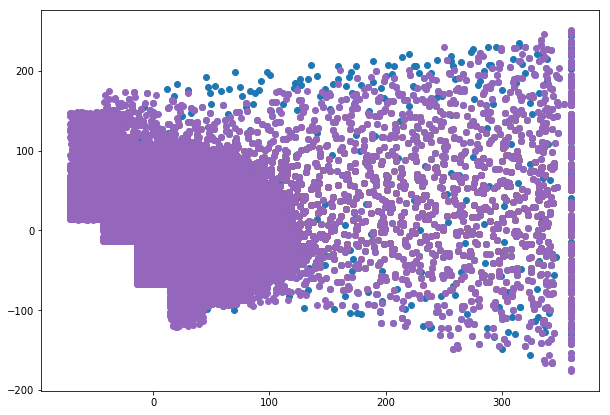

In [254]:
condition_0 = Y.sum(axis=1) > 10**0
condition_1 = Y.sum(axis=1) > 10**-1

condition_2 = Y.sum(axis=1) > 10**-2
condition_3 = Y.sum(axis=1) > 10**-4

np.sum(condition_3)

fig = plt.figure(figsize=(10,7))
ax1 = 'X'
ax2 = 'Y'
plt.scatter(loc_df.loc[condition_3,ax1],loc_df.loc[condition_3,ax2])

plt.scatter(loc_df.loc[condition_2,ax1],loc_df.loc[condition_2,ax2])
plt.scatter(loc_df.loc[condition_1,ax1],loc_df.loc[condition_1,ax2])

plt.scatter(loc_df.loc[condition_0,ax1],loc_df.loc[condition_0,ax2])
plt.scatter(loc_df.loc[A,ax1],loc_df.loc[A,ax2])

In [265]:
def set_to_onehot(A,n):
    """Function that maps a list of points to a one hot encoding of selected points"""
    A_list = np.zeros((n,1))
    A_list[A] = 1
    return A_list

In [271]:
A_list = set_to_onehot(A,data_df.shape[0])
save_vtu(ref_vtu[0],'WorkingSelection10-4.vtu',A_list)

==> Saved to : ../data/temp_data/LSBU_res_2019:07:08-17:41:27_WorkingSelection10-4.vtu
